# Identifying Fraudulent Activities

## Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etc.

Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning. 

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.  

## Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").

These are the tasks you are asked to do:
* For each user, determine her country based on the numeric IP address.
* Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
* Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
* Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

## Data

### Fraud data table
information about each user first transaction
* user_id : Id of the user. Unique by user
* signup_time : the time when the user created her account (GMT time)
* purchase_time : the time when the user bought the item (GMT time)
* purchase_value : the cost of the item purchased (USD)
* device_id : the device id. You can assume that it is unique by device. I.e., 2 transactions with the same device ID means that the same physical device was used to buy
* source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser).
* browser : the browser used by the user.
* sex : user sex: Male/Female
* age : user age
* ip_address : user numeric ip address
* class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).

### IpAddress_to_Country
mapping each numeric ip address to its country. For each country, it gives a range. If the numeric ip address falls within the range, then the ip address belongs to the corresponding country.

* lower_bound_ip_address : the lower bound of the numeric ip address for that country 
* upper_bound_ip_address : the upper bound of the numeric ip address for that country 
* country : the corresponding country. If a user has an ip address whose value is within the upper and lower bound, then she is based in this country.


In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix,roc_curve,classification_report,plot_roc_curve
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydot 
import  warnings
import math
warnings.simplefilter('ignore')

## For each user, determine her country based on the numeric IP address.
### Load Data

In [142]:
data = pd.read_csv('Fraud.csv',parse_dates=['signup_time','purchase_time'])
data=data.iloc[:,1:]
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [143]:
address2country=pd.read_csv('IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


### Determine the country

In [144]:
countries=[]
for ip in data['ip_address']:
    country = list(address2country[(address2country['lower_bound_ip_address']<ip) & (address2country['upper_bound_ip_address']>ip)]['country'].values)
    
    if len(country)==1:
        countries.append(country[0])
    else:
        countries.append(None)


In [145]:
data['countries']=countries

In [146]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
 11  countries       129143 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


## Feature Engineering

A few obvious variables that can be created here could be:
* Time difference between sign-up time and purchase time
* If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
* Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
* Usual week of the year and day of the week from time variables

### Time difference between sign-up time and purchase time

In [148]:
# Get the time difference between purchase time and sign-up time 
data['time_diff']=(data['purchase_time']-data['signup_time']).dt.seconds

### Check uniqueness of device Id

In [149]:
device_num = data[['user_id','device_id']].groupby('device_id').count().reset_index()
device_num.rename(columns={'user_id':'device_num'},inplace=True)

### Check uniqueness of device Id


In [150]:
ip_num = data[['user_id','ip_address']].groupby('ip_address').count().reset_index()
ip_num.rename(columns={'user_id':'ip_num'},inplace=True)

In [151]:
data = data.merge(ip_num,how='left',on='ip_address').merge(device_num,how='left',on='device_id')

In [152]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,countries,time_diff,ip_num,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,8,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None,60085,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1


### Usual week of the year and day of the week from time variables

In [153]:
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [161]:
# select features for future ML analysis
data.rename(columns={'countries':'country'},inplace=True)
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data=data[columns]
data['country']=data['country'].fillna('Not Found')
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,8,1
3,1,18,0,19,44,SEO,Safari,M,41,Not Found,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


## Analysis
### Encode categorical features with value between 0 and n_classes-1

In [162]:
#transfer category variables to numerical category
from sklearn.preprocessing import LabelEncoder
lb_source = LabelEncoder()
lb_browser = LabelEncoder()
lb_sex=LabelEncoder()
lb_country=LabelEncoder()
data['source'] = lb_source.fit_transform(data['source'])
data['browser']=lb_browser.fit_transform(data['browser'])
data['sex']=lb_sex.fit_transform(data['sex'])
data['country']=lb_country.fit_transform(data['country'])

In [165]:
y=data['class']
X=data.drop(['class'],axis=1)

### Splitting data into train and test dataset

In [175]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=101)

### Random Forest

In [167]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,criterion='entropy')
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy')

In [194]:
rfc_pred = rfc.predict(X_test)

#### Confusion Matrix

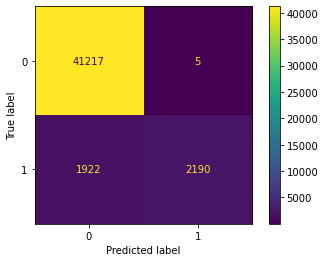

In [242]:
plot_confusion_matrix(rfc,X_test,y_test)


In [195]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41222
           1       1.00      0.53      0.69      4112

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



#### ROC Curve

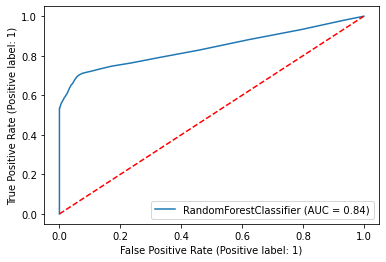

In [206]:
plot_roc_curve(rfc,X_test,y_test)
plt.plot([0,1],[0,1],'r--')

#### Feature Importance

In [178]:
rfc.feature_importances_

array([0.03579618, 0.08139446, 0.03423942, 0.15288063, 0.07162729,
       0.01288785, 0.02379086, 0.01106321, 0.06290645, 0.04353537,
       0.2414467 , 0.15011423, 0.07831736])

In [179]:
rfc.feature_names_in_

array(['signup_day', 'signup_week', 'purchase_day', 'purchase_week',
       'purchase_value', 'source', 'browser', 'sex', 'age', 'country',
       'time_diff', 'device_num', 'ip_num'], dtype=object)

In [185]:
t=sorted(zip(rfc.feature_names_in_,rfc.feature_importances_),key=lambda x:x[1],reverse=True)
importance_pd=pd.DataFrame(t,columns=['Feature','Importance'])

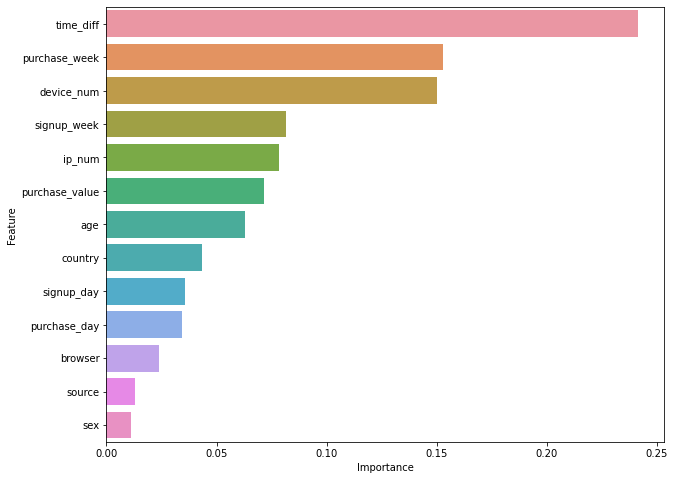

In [187]:
fig,ax=plt.subplots(figsize=(10,8))
sns.barplot(x='Importance',y='Feature',data=importance_pd)
plt.show()

The accuracy of Random forest algorithm is 96% which is great but recall rate is 54%. The model can't perform well on fraudulent activities.

Based on the random forest model, the top 3 important features are time_diff, purchase_week, and device_num.

### Logistic Regression

In [243]:
from sklearn.linear_model import LogisticRegression

In [244]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [225]:
logreg_pred=logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


#### Confusion Matrix

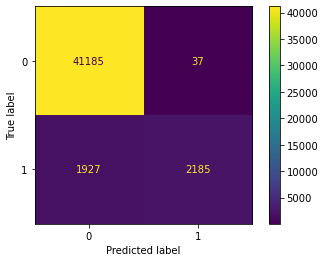

In [241]:
plot_confusion_matrix(logreg,X_test,y_test)

In [240]:
print(classification_report(logreg_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     43112
           1       0.53      0.98      0.69      2222

    accuracy                           0.96     45334
   macro avg       0.77      0.97      0.83     45334
weighted avg       0.98      0.96      0.96     45334



#### ROC  Curve

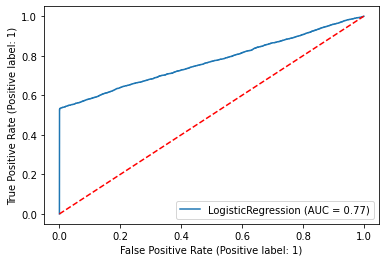

In [228]:
plot_roc_curve(logreg,X_test,y_test)
plt.plot([0,1],[0,1],'r--')

#### feature_importance

In [234]:
w=abs(logreg.coef_[0])

In [236]:
feature_importance_lgr=pd.DataFrame(logreg.feature_names_in_,columns=['Feature'])
feature_importance_lgr['Importance']=100.0*w/w.max()
feature_importance_lgr = feature_importance_lgr.sort_values(by='Importance',ascending=False)

In [237]:
feature_importance_lgr

,Feature,Importance
3,purchase_week,100.000000
11,device_num,75.845196
1,signup_week,50.010337
12,ip_num,36.371565
8,age,6.926728
9,country,4.943097
4,purchase_value,3.549775
6,browser,1.467377
0,signup_day,0.704910
5,source,0.669249


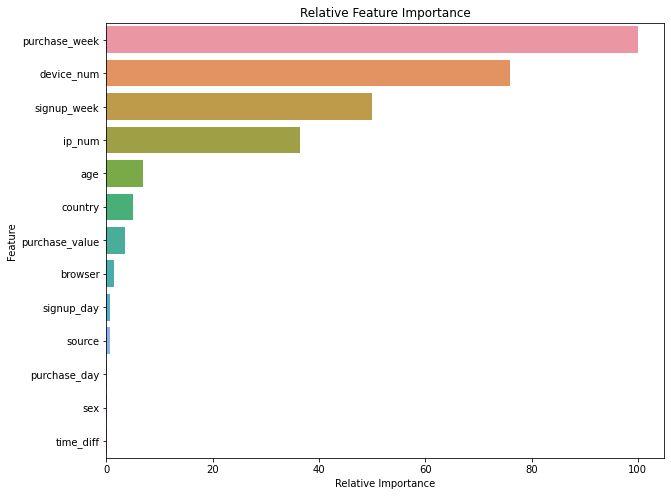

In [239]:
fig,ax=plt.subplots(figsize=(10,8))
sns.barplot(x='Importance',y='Feature',data=feature_importance_lgr)
ax.set_title('Relative Feature Importance')
ax.set_xlabel('Relative Importance')
plt.show()

The accuracy of Logistic Regression is 96% with recall rate as 0.97. AUC is 0.77 better than random forest model.
The top 3 important features are purchase_week, device_num, and signup_week.

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero (this was essentially the random forest output). However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up)

## Conclusion

### From a product perspective, how would you use the model?

For instance:

If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)

If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.

If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.